# Run only once

In [ ]:
data_path = '/content/drive/My Drive/Simulations in Stat learning/data/'
distributions_path = '/content/drive/My Drive/Simulations in Stat learning/distributions/'
videos_path = '/content/drive/My Drive/Simulations in Stat learning/videos/2/'

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!apt install texlive-fonts-recommended texlive-fonts-extra cm-super dvipng

Reading package lists... Done
Building dependency tree       
Reading state information... Done
cm-super is already the newest version (0.3.4-11).
dvipng is already the newest version (1.15-1).
texlive-fonts-extra is already the newest version (2017.20180305-2).
texlive-fonts-recommended is already the newest version (2017.20180305-1).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.


In [ ]:

import matplotlib
matplotlib.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}\usepackage{amsfonts}\usepackage{bm}']
from matplotlib.lines import Line2D

import numpy as np

import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib import pyplot as plt
from matplotlib import animation
import matplotlib
%matplotlib inline
from scipy.stats import multivariate_normal
import pickle
import os

In [ ]:
np.random.seed(42)
#Standard
rc = {
        "xtick.bottom" : True,
        "xtick.labelbottom" : True,
        "xtick.labelsize" : 12,
        'xtick.major.pad' : '7',
        "ytick.labelleft" : True,
        "ytick.labelsize" : 12,
        'ytick.major.pad' : '7',
        "ytick.left" : True,
        "figure.figsize" : (24,18),
        'axes.linewidth' : 7,
        "axes.facecolor": 'white',
        'savefig.facecolor':'blue',
        'text.usetex' : True,

        }
plt.rcParams.update(rc)

## Supporting Functions

In [ ]:
import math
def truncate(number, digits) -> float:
    stepper = 10.0 ** digits
    return math.trunc(stepper * number) / stepper

In [ ]:
#CUSTOM COLORMAPS

label_colors = matplotlib.colors.ListedColormap(['silver', 'Black'])
right_wrong_colors = matplotlib.colors.ListedColormap(['tomato', 'forestgreen'])
hypothesis_colors = matplotlib.colors.ListedColormap(['tomato', 'silver'])


In [ ]:
#norm = colors.Normalize(0, 1)
def get_facecolors(array,mode,alpha = 1):
    shape = array.shape
    p = (-1,)
    if mode == "red":
        colors = right_wrong_colors(array.reshape(-1),alpha)
    if mode == "hypothesis":
        colors = hypothesis_colors(array.reshape(-1),alpha)


    if mode == "black":
        
        #colors = cm.binary(array.reshape(-1),alpha)
        colors = label_colors(array.reshape(-1),alpha)
        
        
    return colors.reshape(shape + p)

In [ ]:
#This get labels is slightly different from the one in hoeffdings inequality notebook
def get_labels(x,y,distribution):
    if distribution == "circle":
        z = np.where(x**2 + y**2 + 2*0.9*x + 2*0.5*y - 0.2 > 0 , 1 , 0)  
        
    elif distribution == "linear":
        h_labeling = np.array([0.7,0.5])
        
        temp = np.c_[x,y]   #---for animation
        z = np.where(np.matmul(temp,h_labeling) - 0> 0.0, 1, 0)
        
    elif distribution =="wiggly1":
        z = np.where(3*y**3 +x**2 -0.2*y**2 +  0*x - 0.01   >0, 1, 0)
        
    elif distribution =="wiggly2":
        z = np.where(30*x**10 + 2*y**10 -700*x**7 + 20*y**5 -1*x**2 + 0.02   >0, 0, 1)
        
    elif distribution == "l1":
        z1 = np.where(abs(x)+abs(y)>0.15,1,0)
        z2 = np.where(abs(x)+abs(y)>0.4,1,0)

        z = np.logical_xor(z1,z2)
    
    else :
        filename = distributions_path + distribution + ".png"
        im = plt.imread(filename)
        image = np.round(np.sum(im,2)/3)

        x_ = np.floor((x + 0.4)*1000)
        y_ = np.floor((y + 0.4)*1000)

        labels = []
        for i,j in zip(x_.astype(int),y_.astype(int)):

            label = image[i,j]
            labels.append(label)

        z = np.abs(1 - np.array(labels))
    
    
        
    return z

In [ ]:
def errors_on_hypothesis_set(data,hypothesis):
    intermediate = np.matmul(data[:,:2], hypothesis)
    predictions = np.where(intermediate > 0.0, 1, 0)
    labels = data[:,2]

    E_out = np.logical_xor(predictions.T,labels)
    true_errors = 1 - np.sum(E_out,axis=1)/E_out.shape[1]
    
    return true_errors,E_out[:8,:],predictions[:,:8]  #this depends on which all hypothesis I want to animate on

In [ ]:
def get_agnostic_data(m):
    
    half_size = int(m/2)
    
    
    rv1 = multivariate_normal([-0.1, -0.1], [[0.03, 0], [0, 0.02]])
    rv2 = multivariate_normal([0.1, 0.1], [[0.01, 0], [0, 0.02]])
    samples_1 = rv1.rvs(size=half_size)
    samples_1 = np.c_[samples_1,np.zeros((half_size,1))]
    
    samples_2 = rv2.rvs(size=half_size)
    samples_2 = np.c_[samples_2,np.ones((half_size,1))]
    d = np.r_[samples_2,samples_1]
    np.random.shuffle(d)
        
    return d

__________________________________________________________________________________________________________________

# KNOBS

In [ ]:


#Variables:
highlighted_hypothesis = 2 #[0-3]
true_distribution_visible = True
black_white_mode = False
interpolation_mode = "iid"  #iid, continuous


#####################
sample_size_to_animate_on = 100  #,200,400
epsilon = 0.1
all_8 = True
find_points = True
if interpolation_mode == "continuous":
  find_points = False



In [ ]:
# Importing shit from the hoeffdings inequality notebook
os.chdir(data_path)

constants = []
PIK = "pickle.dat"
with open(PIK, "rb") as f:
    for _ in range(pickle.load(f)):
        constants.append(pickle.load(f))

true_unknown_distribution = "circle"
is_agnostic = True #constants[2]

specific_hypothesis = highlighted_hypothesis

# All the knobs

In [ ]:
#PAC LEARNING
#All the knobs here
n = sample_size_to_animate_on
distribution = true_unknown_distribution
agnostic = is_agnostic
#interpolation_type = 

if agnostic:
  name = "agnostic"
else:
  name = distribution



e = epsilon
vc_dim = 2

# CHANGE THIS TO CHANGE HYPOTHESIS CLASS..
h4 = np.array([[0,-0.5],
               [-0.5,0],   #the best hypothesis in this toy class..
               [0.5,0],
               [0,0.5],
                ])




hypothesis = h4.T.reshape(2,h4.shape[0])






data = np.load(data_path + "data_"+name+'_'+str(40000)+".npy")
training_data = np.load(data_path + "training_data_"+name+'_'+str(500)+".npy")


training_data = training_data[:n,:]


#data = training_data[:2,:]
#training_data = np.c_[training_data[0,:],training_data[0,:]].T

#Useful when saving file

if true_distribution_visible == False:
  name = name + "_training_only_"


# do big matrix multiplications


In [ ]:

true_errors,E_out,p_true = errors_on_hypothesis_set(data,hypothesis)
in_sample_errors,E_in,_ = errors_on_hypothesis_set(training_data,hypothesis)

In [ ]:
#Taking a slice for the current hypothesis. First 8 are going to be SPECIFIC hypothesis
if all_8:
  E_out = E_out[:4,:]
  p_true = p_true[:,:4]
else:
  E_out = E_out[0,:]
  p_true = p_true[:,0]

___________________________________________________________________________________________________________________________

# Plotting

In [ ]:
data.shape

(40000, 3)

Text(-1.22, -1.53, 'The data scientist chooses a (toy) hypothesis class which, they believe, contains\n a hypothesis with a low true error. A point in this space is a particular setting\n of weight 1 and weight 2. For simplicity, bias is fixed at 0.')

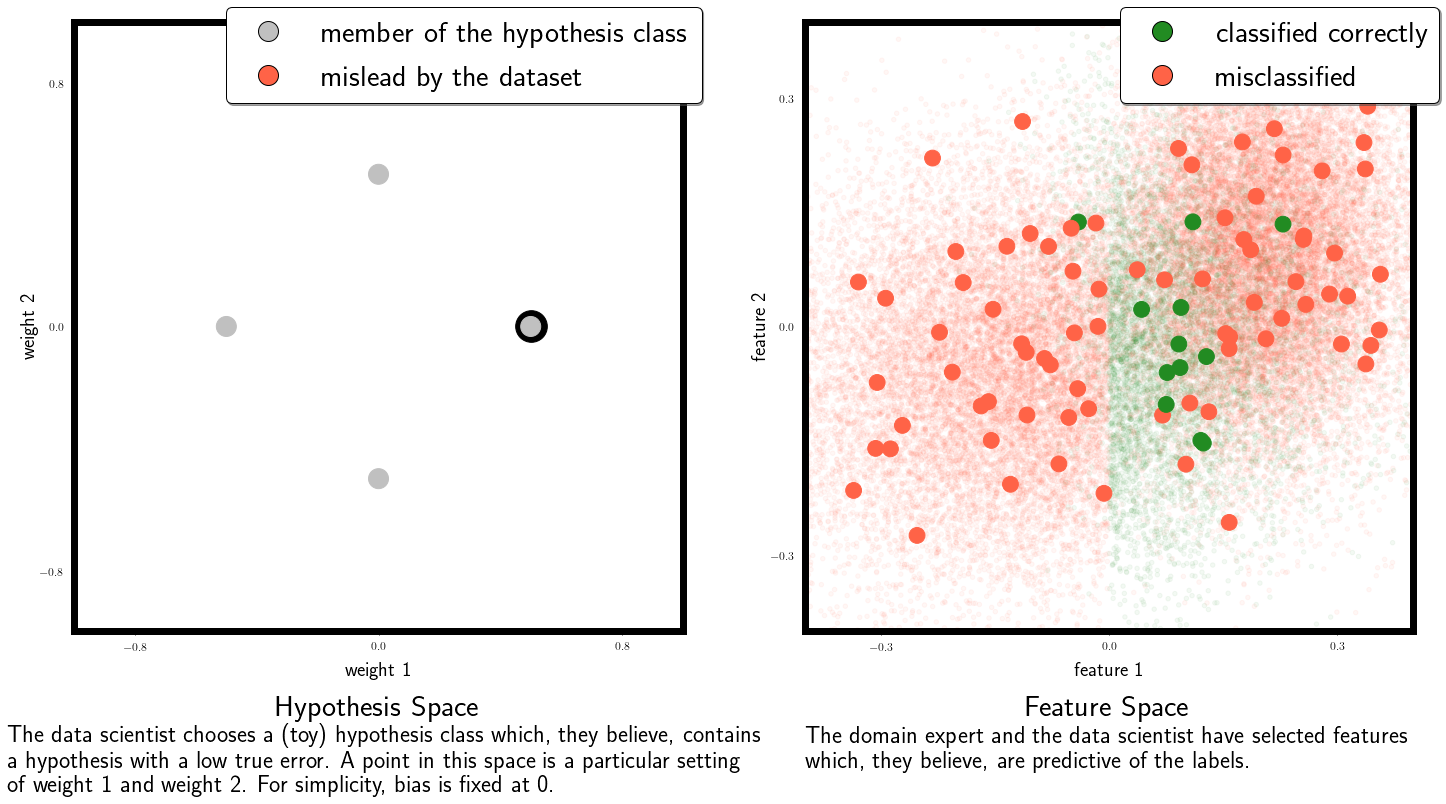

In [ ]:
#Formatting the plot
fig, axs = plt.subplots(1, 2)
plt.autoscale(False)


axs[0].set_xlim([-0.4, 0.4])
axs[0].set_ylim([-0.4, 0.4])
axs[0].xaxis.set_major_locator(plt.MaxNLocator(3))
axs[0].yaxis.set_major_locator(plt.MaxNLocator(3))
axs[0].set_aspect(aspect='equal', adjustable='box')

axs[1].set_xlim([-1, 1])
axs[1].set_ylim([-1, 1])
axs[1].xaxis.set_major_locator(plt.MaxNLocator(3))
axs[1].yaxis.set_major_locator(plt.MaxNLocator(3))
axs[1].set_aspect(aspect='equal', adjustable='box')

# Now we'll swap their positions after they've been created.
pos1 = axs[1].get_position()
axs[1].set_position(axs[0].get_position())
axs[0].set_position(pos1)



#When animating the hypothesis I need to have a reference over this
if true_distribution_visible: #Fix this, hypothesis does not get highlighted when the distribution is not visible
  if all_8:
    axs[0].scatter(data[:,0],data[:,1],c=right_wrong_colors(E_out[highlighted_hypothesis,:],0.05),s = 20)
    sample_space_2  = axs[0].scatter(training_data[:,0],training_data[:,1],c=right_wrong_colors(E_in[highlighted_hypothesis,:],1),s = 250)
    axs[1].scatter(hypothesis[0,highlighted_hypothesis],hypothesis[1,highlighted_hypothesis],color='black',s=1000) #2 is the hypothesis which is highlighted
  



  diff = np.abs(true_errors - in_sample_errors)
  hypothesis_space_2 = axs[1].scatter(hypothesis[0,:],hypothesis[1,:],c = hypothesis_colors(diff<e,1),s=400)
else:
  if black_white_mode:
    if all_8:

      sample_space_2  = axs[0].scatter(training_data[:,0],training_data[:,1],c=label_colors(training_data[:,2],1),s = 250)
      
   
    
    
    diff = np.abs(true_errors - in_sample_errors)
    hypothesis_space_2 = axs[1].scatter(hypothesis[0,:],hypothesis[1,:],c = hypothesis_colors(diff<e,1),s=400)
  else:
    if all_8:
     
      sample_space_2  = axs[0].scatter(training_data[:,0],training_data[:,1],c=right_wrong_colors(E_in[highlighted_hypothesis,:],1),s = 250)
      axs[1].scatter(hypothesis[0,highlighted_hypothesis],hypothesis[1,highlighted_hypothesis],color='black',s=1000) #2 is the hypothesis which is highlighted
    
    
    diff = np.abs(true_errors - in_sample_errors)
    hypothesis_space_2 = axs[1].scatter(hypothesis[0,:],hypothesis[1,:],c = hypothesis_colors(diff<e,1),s=400)


if black_white_mode:

    line1 = Line2D(range(1), range(1), linewidth=0,color="black", marker='o',markersize=20, markerfacecolor="lightgrey")
    line2 = Line2D(range(1), range(1), linewidth=0,color="black", marker='o',markersize=20,markerfacecolor="black")
    l=axs[0].legend((line1,line2),('label a','label b'),prop={'size': 30},frameon=True,loc='upper center', bbox_to_anchor=(0.9, 1.05),ncol=1, fancybox=True, shadow=True)
    frame = l.get_frame()
    #frame.set_facecolor('white')
    frame.set_edgecolor('black')
else:
    line1 = Line2D(range(1), range(1), linewidth=0,color="black", marker='o',markersize=20, markerfacecolor="forestgreen")
    line2 = Line2D(range(1), range(1), linewidth=0,color="black", marker='o',markersize=20,markerfacecolor="tomato")
    l=axs[0].legend((line1,line2),('classified correctly','misclassified'),prop={'size': 30},frameon=True,loc='upper center', bbox_to_anchor=(0.78, 1.05),ncol=1, fancybox=True, shadow=True)
    frame = l.get_frame()
    #frame.set_facecolor('white')
    frame.set_edgecolor('black')

if not true_distribution_visible:
    
    line1 = Line2D(range(1), range(1), linewidth=0,color="black", marker='o',markersize=20, markerfacecolor="silver")
    #line2 = Line2D(range(1), range(1), linewidth=0,color="black", marker='o',markersize=20,markerfacecolor="tomato")
    l=axs[1].legend([line1],[r'$ \text{member of the hypothesis class}$'],prop={'size': 30},frameon=True,loc='upper center', bbox_to_anchor=(0.64, 1.05),ncol=1, fancybox=True, shadow=True)
    #l=axs[0].legend((line1,line2),(r'$ \text{diff}<\bm{\varepsilon}$',r'$ \text{diff}>\bm{\varepsilon}$'),prop={'size': 30},frameon=True,loc='upper center', bbox_to_anchor=(0.9, 1.05),ncol=1, fancybox=True, shadow=True)
    frame = l.get_frame()
    frame.set_edgecolor('black')
else:
    line1 = Line2D(range(1), range(1), linewidth=0,color="black", marker='o',markersize=20, markerfacecolor="silver")
    line2 = Line2D(range(1), range(1), linewidth=0,color="black", marker='o',markersize=20,markerfacecolor="tomato")
    l=axs[1].legend((line1,line2),(r'$ \text{member of the hypothesis class}$',r'$ \text{mislead by the dataset}$'),prop={'size': 30},frameon=True,loc='upper center', bbox_to_anchor=(0.64, 1.05),ncol=1, fancybox=True, shadow=True)
    #l=axs[0].legend((line1,line2),(r'$ \text{diff}<\bm{\varepsilon}$',r'$ \text{diff}>\bm{\varepsilon}$'),prop={'size': 30},frameon=True,loc='upper center', bbox_to_anchor=(0.9, 1.05),ncol=1, fancybox=True, shadow=True)
    frame = l.get_frame()
    frame.set_edgecolor('black')




#Caption ,title control
axs[0].xaxis.set_major_locator(plt.MaxNLocator(3))
axs[0].yaxis.set_major_locator(plt.MaxNLocator(3))
axs[0].set_xlabel('feature 1',fontsize = 20,labelpad=10)
axs[0].set_ylabel('feature 2',fontsize = 20,labelpad=1)
axs[0].set_title("Feature Space",y = -0.15,fontsize = 30)
txt="The domain expert and the data scientist have selected features\n which, they believe, are predictive of the labels."
axs[0].text(-0.40, -0.58, txt, ha='left',fontsize = 24)  


#text and axis labels
axs[1].xaxis.set_major_locator(plt.MaxNLocator(3))
axs[1].yaxis.set_major_locator(plt.MaxNLocator(3))
axs[1].set_xlabel('weight 1',fontsize = 20,labelpad=10)
axs[1].set_ylabel('weight 2',fontsize = 20,labelpad=1)
axs[1].set_title("Hypothesis Space",y = -0.15,fontsize = 30)
txt="The data scientist chooses a (toy) hypothesis class which, they believe, contains\n a hypothesis with a low true error. A point in this space is a particular setting\n of weight 1 and weight 2. For simplicity, bias is fixed at 0."
#axs[1].text(-0.5, -0.616, txt, ha='left',fontsize = 24) 
axs[1].text(-1.22, -1.53, txt, ha='left',fontsize = 24) 






# Just moving in the sample space

In [ ]:
def get_linear_interpolated_points(current_points,final_points,frames):
    shape = current_points.shape
    diff = final_points.reshape(-1) - current_points.reshape(-1)
    offset = diff/frames
    interpolated_points = []
    for i in range(frames):
        points_n = current_points.reshape(-1) + offset*i
        interpolated_points.append(points_n.reshape(shape))
    return np.array(interpolated_points)

In [ ]:
#change this to consider agnostic case
og_points = training_data[:,:2].copy()
if interpolation_mode == "continuous":

  num_of_samples = 5
  frames_scale = 50 
  frames = frames_scale*num_of_samples




  #get the points which are GREEN
  if all_8:
    choose_from = np.c_[data[:,0],data[:,1],E_out[highlighted_hypothesis,:],p_true[:,highlighted_hypothesis]] #h_predictions is for a particular hypothesis


  greens = np.where(choose_from[:,2] == 1 ) 
  greens = choose_from[greens[0],:]
  greens_half = np.where(greens[:,3] == 1)
  greens_half = greens[greens_half[0],:]

  reds = np.where(choose_from[:,2] == 0 ) 
  reds = choose_from[reds[0],:]
  reds_half = np.where(reds[:,3] == 1)
  reds_half = reds[reds_half[0],:]

  #Sample from the points which are green

  current_points = last_iid_red_point.copy() 
  interpolated_points = []
  for i in range(num_of_samples):
      
      green_rows = np.random.randint(0,greens_half.shape[0],n)
      red_rows = np.random.randint(0,reds_half.shape[0],n)
      if i == (num_of_samples-1):
        final_points = og_points
      elif i == (num_of_samples-2):
        final_points = reds_half[red_rows,:2]
      elif i == (num_of_samples-3):
        final_points = reds_half[red_rows,:2]

      else:
        final_points = greens_half[green_rows,:2]

      ip = get_linear_interpolated_points(current_points,final_points,frames = frames_scale)
      interpolated_points.append(ip)
      current_points = final_points.copy()

  interpolated_points = np.array(interpolated_points).reshape(-1,n,2)

if interpolation_mode == "iid":
  if find_points == True:
    temp_frames = 300000

    if is_agnostic:
      for x in range(temp_frames):
        temp_sample = 
      iid_samples = get_agnostic_data()               #np.random.uniform(-0.4,0.4,[temp_frames,n,2])
    else:
      iid_samples = np.random.uniform(-0.4,0.4,[temp_frames,n,2])
    interpolation_intermediate = np.matmul(iid_samples,hypothesis)
    interpolation_predictions = np.where(interpolation_intermediate > 0.0, 1, 0)
    interpolation_labels = get_labels(iid_samples[:,:,0].reshape(n*temp_frames),iid_samples[:,:,1].reshape(n*temp_frames),distribution).reshape(temp_frames,-1,1)
    interpolation_in_error =1 - np.sum(np.logical_xor(interpolation_predictions, interpolation_labels),axis=1)/iid_samples.shape[1]
    interpolation_diff = np.abs(interpolation_in_error - true_errors)


    if all_8:
      how_many_h_red = np.where(interpolation_diff<e*1.4,0,1)
      x = np.sum(how_many_h_red,1)

      red_point_indices = np.where(x > 0)
      white_point_indices = np.where(x == 0)

      white_points = iid_samples[white_point_indices[0][:4],:,:]       ############            NEED MORE RED POINTS?
      red_points = iid_samples[red_point_indices[0][:4],:,:]

      interpolated_points = np.r_[og_points.reshape(1,n,2),white_points,red_points]
      last_iid_red_point = interpolated_points[-1,:,:].copy()

      frames = interpolated_points.shape[0]
      np.save(data_path+"_iid_interpolation_"+str(n)+".npy",interpolated_points)



  else:
    interpolated_points = np.load(data_path+"_iid_interpolation_"+str(n)+".npy")
    last_iid_red_point = interpolated_points[-1,:,:].copy()
  #  frames = interpolated_points.shape[0]




In [ ]:
interpolated_points.shape[0]

9

In [ ]:
# probability of drawing an e-representative sample is atleast 0.94 (according to hoeffdings bound.)

In [ ]:
#white_point_indices[0].shape[0]/temp_frames  #empirical probability of getting an e-representative sample

In [ ]:
if interpolation_mode == "continuous":
  fps=30
  interval = 10
else:
  if not true_distribution_visible:
    interpolated_points = interpolated_points[[0],:,:].copy()
    temp = np.broadcast_to(interpolated_points, (10, interpolated_points.shape[0],sample_size_to_animate_on,2))
    interpolated_points = temp.reshape(10*interpolated_points.shape[0],sample_size_to_animate_on,2,order='F')
    frames = interpolated_points.shape[0]

    fps=10
    interval = 1000
  else:
    temp = np.broadcast_to(interpolated_points, (10, interpolated_points.shape[0],sample_size_to_animate_on,2))
    interpolated_points = temp.reshape(10*interpolated_points.shape[0],sample_size_to_animate_on,2,order='F')
    frames = interpolated_points.shape[0]

    fps=10
    interval = 1000



# Calculate the facecolors to be used in the animation

In [ ]:


#interpolated points has the shape [frame,n(sample size),2( 2dimensional)]
interpolation_intermediate = np.matmul(interpolated_points,hypothesis)
interpolation_predictions = np.where(interpolation_intermediate > 0.0, 1, 0)

#interpolation_labels = np.where(np.matmul(interpolated_points,labeling_hypothesis) > 0, 1, 0)
interpolation_labels = get_labels(interpolated_points[:,:,0].reshape(n*frames),interpolated_points[:,:,1].reshape(n*frames),distribution).reshape(frames,-1,1)
if all_8:
  right_wrong = np.logical_xor(interpolation_labels.reshape(frames,-1),interpolation_predictions[:,:,highlighted_hypothesis])
else:
  right_wrong = np.logical_xor(interpolation_labels.reshape(frames,-1),interpolation_predictions[:,:,0])

if black_white_mode:
  interpolation_label_facecolors = get_facecolors(interpolation_labels.reshape(frames,-1),mode = "black")
else:
  interpolation_label_facecolors = get_facecolors(right_wrong,mode = "red")

interpolation_in_error =1 - np.sum(np.logical_xor(interpolation_predictions, interpolation_labels),axis=1)/interpolated_points.shape[1]
interpolated_in_error_facecolors = get_facecolors(interpolation_in_error,mode="black")

interpolation_diff = np.abs(interpolation_in_error - true_errors)
interpolated_facecolors = get_facecolors(interpolation_diff<e,mode="hypothesis")


In [ ]:
#Errors display:
E_outs = true_errors
E_ins = interpolation_in_error
difference = interpolation_diff

In [ ]:
interpolation_diff.shape

(10, 4)



# POints Animation 

In [ ]:

def animate(i,interpolated_points,interpolated_facecolors,interpolated_in_error_facecolors,interpolation_in_error,interpolation_label_facecolors):
    
    sample_space_2.set_offsets(interpolated_points[i,:,:])
    sample_space_2.set_facecolors(interpolation_label_facecolors[i,:,:])
        
    hypothesis_space_2.set_facecolors(interpolated_facecolors[i,:,:])
    
    #Setting E_in value
    #e_in_text.set_text("Train error : {:.3f}".format(interpolation_in_error[i,0]))

    return sample_space_2,hypothesis_space_2,

In [ ]:
ani = animation.FuncAnimation(fig, animate, fargs=(interpolated_points,interpolated_facecolors,interpolated_in_error_facecolors,interpolation_in_error,interpolation_label_facecolors,),
            frames=frames, interval=interval, repeat=False,blit = True) 

if all_8:
  knob = "outof4_" + interpolation_mode 

if black_white_mode:
  file_name = "grey"
else:
  if true_distribution_visible:
    file_name = "/god/" + name + str(sample_size_to_animate_on)+'_'+str(specific_hypothesis+1)+knob
  else:
    file_name = "/training/" + name + str(sample_size_to_animate_on)+'_'+str(specific_hypothesis+1)+knob



ani.save(videos_path+file_name+'.mp4', fps=fps, extra_args=['-vcodec', 'libx264'],savefig_kwargs=dict(facecolor='blue'))

# Table animation

In [ ]:
interpolated_points.shape

(10, 300, 2)

In [ ]:
if all_8: #You can put any fucking number instead of highlighted hypothesis here. It doesn't really matter
  cell_data = np.c_[E_ins[5,:],E_outs,difference[5,:]].T
else:
  cell_data = np.c_[E_ins[5,:],E_outs,difference[5,:]].T

In [ ]:
table_rc = {"axes.spines.left" : False,
      "axes.spines.right" : False,
      "axes.spines.bottom" : False,
      "axes.spines.top" : False,
      "xtick.bottom" : False,
      "xtick.labelbottom" : False,
      "ytick.labelleft" : False,
      "ytick.left" : False,
      'savefig.facecolor':'blue',
      'axes.facecolor' : 'blue',
      "figure.figsize" : (16,3),
      "savefig.dpi" : 119,
      'text.usetex' : True,
      'text.latex.preamble': r'\boldmath'}

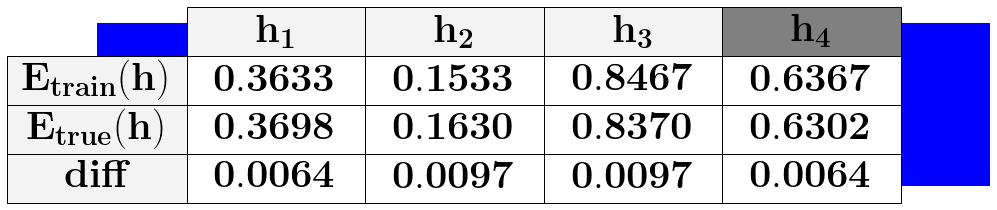

In [ ]:
if all_8:
  #Table parameters:
  height = 0.3
  width = 0.2

  rcolors = plt.cm.Greys(np.full(hypothesis.shape[1], 0.1))
  ccolors = plt.cm.Greys( 0.1)

  with plt.rc_context(table_rc):
    fig_table, ax = plt.subplots()

    # Hide axes
    ax.xaxis.set_visible(False) 
    ax.yaxis.set_visible(False)

  #rows = ('Training Error', 'True Error', "Difference")
    rows = (r'$\mathbf{E_{ train}(h)}$', r'$\mathbf{E_{ true}(h)}$', r'$\mathbf{diff}$')
    columns = [r'$\mathbf{{h}_{'+ str(x+1)+'}}$' for x in range(difference.shape[1])]



    the_table = ax.table(cellText = cell_data,
                          rowLabels=rows,
                          rowColours = rcolors,
                          colLabels=columns,
                          cellLoc='center',
                          loc='center',
                          colWidths=[width for x in columns],
                    
                          )
    the_table.set_fontsize(40)
   
    

    cellDict = the_table.get_celld()

    for i in range(0,len(columns)):
        for j in range(0,len(rows)+1):
            cellDict[(j,i)].set_height(height)

    for i in range(1,4):
      cellDict[(i,-1)].set_height(height)
      cellDict[(i,-1)]._loc = 'center'

    for i in range(4):
      cellDict[(0,i)].set_facecolor(ccolors)

      true_txt = '{:.4f}'.format(E_outs[i])
      cellDict[(2,i)].get_text().set_text(r'$\mathbf{'+str(true_txt)+'}$')
    
      diff_txt = '{:.4f}'.format(difference[5,i])
      cellDict[(3,i)].get_text().set_text(r'$\mathbf{'+str(diff_txt)+'}$')

      train_txt = '{:.4f}'.format(E_ins[5,i])
      cellDict[(1,i)].get_text().set_text(r'$\mathbf{'+str(train_txt)+'}$')


    c=the_table.get_celld()[(0,highlighted_hypothesis)]
    c.set_facecolor('grey')
    



In [ ]:
def animate_table(i,E_ins,E_outs,difference,):
    
    #Set all difference cells as white
    for x in range(hypothesis.shape[1]):
      the_table.get_celld()[(3,x)].set_facecolor('w')

    for x in range(hypothesis.shape[1]):
      training_txt = '{:.4f}'.format(E_ins[i,x])
      diff_txt = '{:.4f}'.format(difference[i,x])

      the_table.get_celld()[(1,x)].get_text().set_text(r'$\mathbf{'+str(training_txt)+'}$') 
      the_table.get_celld()[(3,x)].get_text().set_text(r'$\mathbf{'+str(diff_txt)+'}$' ) 
      if difference[i,x] > e:
        the_table.get_celld()[(3,x)].set_facecolor('tomato')

    


    return the_table,

In [ ]:
ani_table = animation.FuncAnimation(fig_table, animate_table, fargs=(E_ins,E_outs,difference,),
            frames=frames, interval=interval, repeat=False,blit = False) 

if all_8:
  knob = "outof4_" + interpolation_mode 

if black_white_mode:
  file_name = "table_grey"
else:
  if true_distribution_visible:
    file_name = "/god/table" + name + str(sample_size_to_animate_on)+'_'+str(specific_hypothesis+1)+knob
  else:
    file_name = "/training/table" + name + str(sample_size_to_animate_on)+'_'+str(specific_hypothesis+1)+knob


ani_table.save(videos_path + file_name+'.mp4', fps=fps, extra_args=['-vcodec', 'libx264'],savefig_kwargs=dict(facecolor='blue'))